In [1]:
import numpy as np
import cv2
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import glob

2022-10-20 18:45:17.871259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 18:45:21.592575: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-20 18:45:30.541779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/petrucho/cv_project/.venv/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-20 18:45:30.541956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_

In [2]:
!pwd

/home/petrucho/cv_project


In [ ]:
# Its for Colab
# create dirs

# train_input_path = '/kaggle/working/train/input_images/'
# train_target_path = '/kaggle/working/train/target_images/'

# test_input_path = '/kaggle/working/test/input_images/'
# test_target_path = '/kaggle/working/test/target_images/'


# os.makedirs(train_input_path+"train/")
# os.makedirs(train_target_path+"train_cleaned/")

# os.makedirs(test_input_path)
# os.makedirs(test_target_path)

In [ ]:
# Its for Colab
# Add new data 

# os.makedirs('/kaggle/working/denoising-dirty-documents/')

# !unzip /kaggle/input/denoising-dirty-documents/train_cleaned.zip -d /kaggle/working/denoising-dirty-documents/
# !unzip /kaggle/input/denoising-dirty-documents/train.zip -d /kaggle/working/denoising-dirty-documents/

# !cp -ar /kaggle/working/denoising-dirty-documents/train/* /kaggle/working/train/input_images/train
# !cp -ar /kaggle/working/denoising-dirty-documents/train_cleaned/* /kaggle/working/train/target_images/train_cleaned

In [7]:
# create dirs

train_input_path = '/home/petrucho/cv_project/data/train/input_images/'
train_target_path = '/home/petrucho/cv_project/data/train/target_images/'

test_input_path = '/home/petrucho/cv_project/data/test/input_images/'
test_target_path = '/home/petrucho/cv_project/data/test/target_images/'


os.makedirs(train_input_path+"train/", exist_ok = True)
os.makedirs(train_target_path+"train_cleaned/", exist_ok = True)

os.makedirs(test_input_path, exist_ok = True)
os.makedirs(test_target_path, exist_ok = True)

In [ ]:
# Its for Colab
# Add new data

# os.makedirs('/kaggle/working/denoising-dirty-documents/')

# !unzip /kaggle/input/denoising-dirty-documents/train_cleaned.zip -d /kaggle/working/denoising-dirty-documents/
# !unzip /kaggle/input/denoising-dirty-documents/train.zip -d /kaggle/working/denoising-dirty-documents/

# !cp -ar /kaggle/working/denoising-dirty-documents/train/* /kaggle/working/train/input_images/train
# !cp -ar /kaggle/working/denoising-dirty-documents/train_cleaned/* /kaggle/working/train/target_images/train_cleaned

In [23]:
# training params

batch_size = 32
epoch_size = 10

In [18]:
# create training generators

train_input_data_gen = ImageDataGenerator(rescale=1./255)
train_target_data_gen = ImageDataGenerator(rescale=1./255)

train_input_image_generator = train_input_data_gen.flow_from_directory(
    train_input_path,
    batch_size=batch_size,
    color_mode = 'grayscale',
    target_size=(400, 400),
    class_mode=None,
    shuffle=False,
    seed=0)

train_target_image_generator = train_target_data_gen.flow_from_directory(
    train_target_path,
    batch_size=batch_size,
    color_mode = 'grayscale',
    target_size=(400, 400),
    class_mode=None,
    shuffle=False,
    seed=0)

train_generator = zip(train_input_image_generator, train_target_image_generator)

Found 144 images belonging to 1 classes.
Found 144 images belonging to 1 classes.


In [11]:
!pip install ipywidgets

  Using cached ipywidgets-8.0.2-py3-none-any.whl (134 kB)
  Using cached jupyterlab_widgets-3.0.3-py3-none-any.whl (384 kB)
  Using cached widgetsnbextension-4.0.3-py3-none-any.whl (2.0 MB)


In [12]:
import torch

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


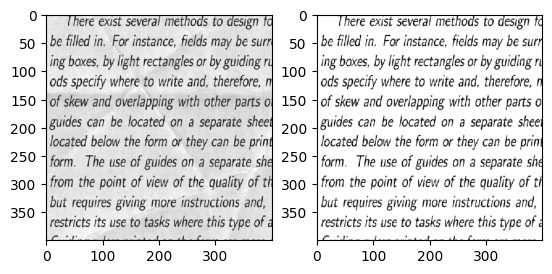

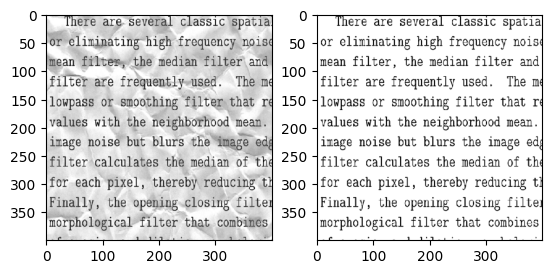

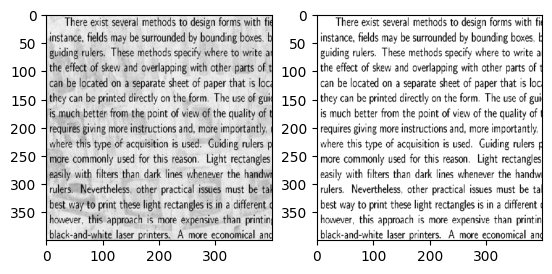

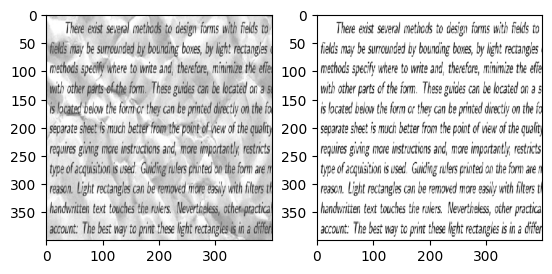

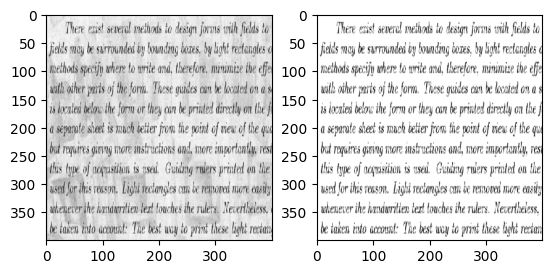

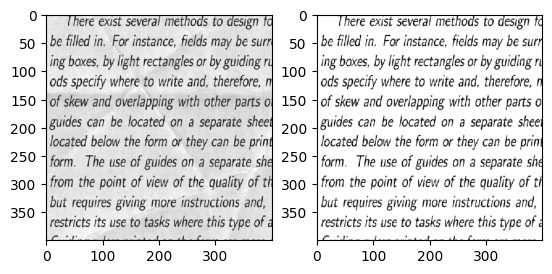

In [20]:
# Display some training images and target images

from matplotlib import pyplot as plt

n = 0
for train, target in zip(train_input_image_generator, train_target_image_generator):
    plt.figure()
    plt.subplot(121)
    plt.imshow((train[0][:,:,0]*255).astype('uint8'),cmap='gray')
    plt.subplot(122)
    plt.imshow((target[0][:,:,0]*255).astype('uint8'),cmap='gray')
    n+=1
    if n >5:
        break

In [21]:
# Create model

def autoencoder():

    model = Sequential()

    # input layer
    model.add(layers.Input(shape=(400,400, 1)))

    # encoder section
    model.add(layers.Conv2D(32, (3, 3), activation='relu',strides=2,padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',strides=2,padding='same'))
    model.add(layers.BatchNormalization())
    

    # decoder section
    model.add(layers.Conv2DTranspose(64, (3, 3), activation='relu',strides=2,padding='same'))
    model.add(layers.Conv2DTranspose(32, (3, 3), activation='relu',strides=2,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(1, (3, 3), activation='sigmoid',strides=1, padding='same'))

    # compile model
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    #print model summary
    model.summary()

    return model

# create model
model = autoencoder()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 200, 200, 32)      320       
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 batch_normalization_2 (Batc  (None, 100, 100, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 200, 200, 64)     36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 400, 400, 32)     18464     
 ranspose)                                                       
                                                      

In [24]:
torch.cuda.empty_cache()

In [25]:
# fit model

training_sample = train_input_image_generator.samples

model.fit(
        train_generator,
        steps_per_epoch=np.ceil(training_sample/batch_size),
        epochs=epoch_size,
        )

Epoch 1/10
5/5 [==============================] - 66s 14s/step - loss: 0.0876 - mae: 0.2226
Epoch 2/10
5/5 [==============================] - 69s 13s/step - loss: 0.0710 - mae: 0.1937
Epoch 3/10
5/5 [==============================] - 66s 13s/step - loss: 0.0588 - mae: 0.1749
Epoch 4/10
5/5 [==============================] - 67s 13s/step - loss: 0.0497 - mae: 0.1592
Epoch 5/10
5/5 [==============================] - 71s 14s/step - loss: 0.0427 - mae: 0.1457
Epoch 6/10
5/5 [==============================] - 70s 13s/step - loss: 0.0370 - mae: 0.1354
Epoch 7/10
5/5 [==============================] - 72s 14s/step - loss: 0.0320 - mae: 0.1266
Epoch 8/10
5/5 [==============================] - 72s 14s/step - loss: 0.0279 - mae: 0.1183
Epoch 9/10
5/5 [==============================] - 73s 14s/step - loss: 0.0244 - mae: 0.1108
Epoch 10/10
5/5 [==============================] - 69s 13s/step - loss: 0.0216 - mae: 0.1037


In [26]:
!pwd

/home/petrucho/cv_project


In [27]:
%cd /home/petrucho/cv_project/data/

/home/petrucho/cv_project/data


In [28]:
!git clone https://github.com/kwcckw/shabby_images/

Cloning into 'shabby_images'...
remote: Enumerating objects: 2150, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2150 (delta 0), reused 4 (delta 0), pack-reused 2146
Receiving objects: 100% (2150/2150), 326.31 MiB | 10.22 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (2146/2146), done.


In [29]:
test_input_path = "/home/petrucho/cv_project/data/shabby_images/Datasets/test"

In [30]:
def preprocess(path):

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = np.asarray(img, dtype="float32")
    img = img/255.0 #Scaling the pixel values
    
    return img.reshape(400,400,1)

In [31]:
# get testing image

img_test_path = sorted(glob.glob(test_input_path+'/input/*'))

test_imgs = []
for file_path in img_test_path:
    test_imgs.append(preprocess(file_path))
test_imgs = np.asarray(test_imgs)

In [32]:
# get cleaned images using trained model

img_predicted = model.predict(test_imgs, batch_size=2)
for i, (predicted, testing_path) in enumerate(zip(img_predicted, img_test_path)):
    predicted_sequeeze = (np.squeeze(predicted) * 255).astype("uint8")
    cv2.imwrite(test_target_path+os.path.basename(testing_path), predicted_sequeeze)

150/150 [==============================] - 50s 328ms/step


In [33]:
# get cleaned images (optional)

from IPython.display import FileLink

!zip -r output_images.zip /home/petrucho/cv_project/data/test/target_images/
FileLink(r'output_images.zip')

  adding: home/petrucho/cv_project/data/test/target_images/ (stored 0%)
  adding: home/petrucho/cv_project/data/test/target_images/0150-HSE_indg143.pdf-07.png (deflated 73%)
  adding: home/petrucho/cv_project/data/test/target_images/0444-CityofPage_Pay-Grades-Website.pdf-2.png (deflated 69%)
  adding: home/petrucho/cv_project/data/test/target_images/0007-Census-hsv_currenthvspress.pdf-03.png (deflated 56%)
  adding: home/petrucho/cv_project/data/test/target_images/0358-PerfectEnglishGrammar_tenses-infographics.pdf-05.png (deflated 72%)
  adding: home/petrucho/cv_project/data/test/target_images/0103-stmaryshealthcaresystem-medical-group-docs_standard-medical-history-june_2020.pdf-4.png (deflated 74%)
  adding: home/petrucho/cv_project/data/test/target_images/0069-mysurgerywebsite_New_Registration_Pack.pdf-08.png (deflated 70%)
  adding: home/petrucho/cv_project/data/test/target_images/0433-EBU-laws-and-ethics_blue-book.pdf-29.png (deflated 54%)
  adding: home/petrucho/cv_project/data/te

/home/petrucho/cv_project/data/output_images.zip

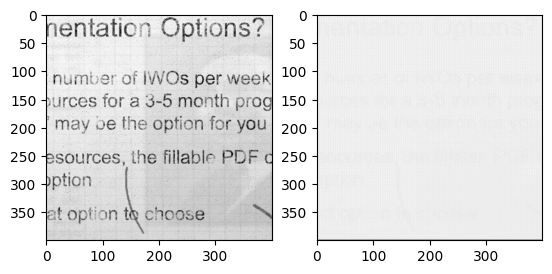

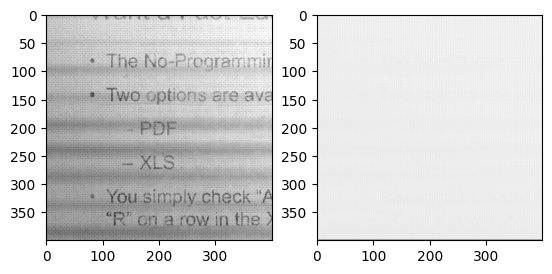

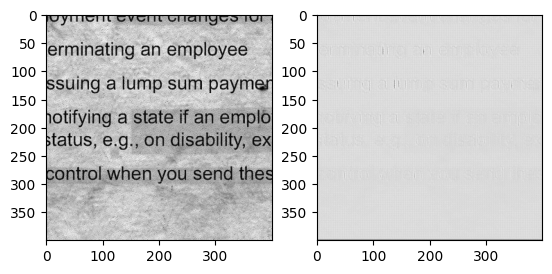

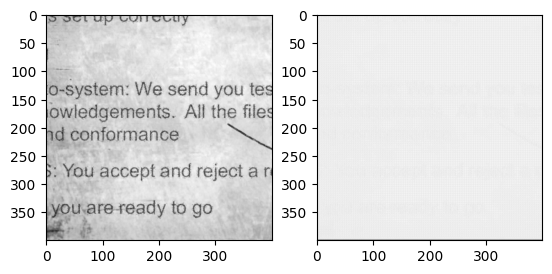

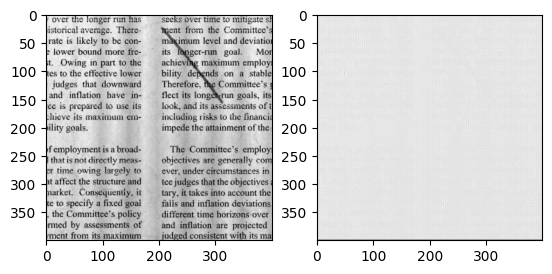

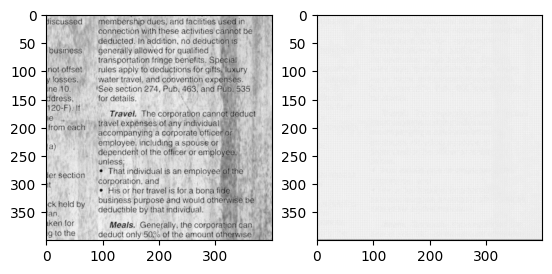

In [34]:
# Display some input testing image and cleaned image from the model

from matplotlib import pyplot as plt

n = 0
for noisy_path in img_test_path:
    
    clean_path = test_target_path + os.path.basename(noisy_path)
    
    img_noisy = cv2.imread(noisy_path, cv2.IMREAD_GRAYSCALE)
    img_clean = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE)
    
    plt.figure()
    plt.subplot(121)
    plt.imshow(img_noisy,cmap='gray')
    plt.subplot(122)
    plt.imshow(img_clean,cmap='gray')
    n+=1
    if n >5:
        break

In [35]:
# create submission file


cleaned_images_dir = '/home/petrucho/cv_project/data/test/target_images/'

def select_pixels(img):
    y,x = img.shape

    pixels = list()

    for i in range(10000):
        pixel = (random.randrange(y), random.randrange(x))

        if pixel not in pixels:
            pixels.append(pixel)

    return pixels


random.seed(0)

cleaned_images = sorted(os.listdir(cleaned_images_dir))

with open("submission.csv", "w") as submission_file:
    submission_file.write("id,predicted\n")

    print("Processing images...")
    filenum = 1
    for image in tqdm(cleaned_images):
        
        img = cv2.imread(cleaned_images_dir + image, cv2.IMREAD_GRAYSCALE)
        pixels = select_pixels(img)

        for pixel in pixels:
            y,x = pixel
            submission_file.write("{}_{}_{},{}\n".format(filenum, y, x, img[y][x]/255.0))

        filenum += 1
    print('Done!')

Processing images...


100%|██████████| 300/300 [10:50<00:00,  2.17s/it]

Done!


In [36]:
# get submission file

from IPython.display import FileLink

FileLink(r'submission.csv')

/home/petrucho/cv_project/data/submission.csv